## 6. Long Short Term Memory (LSTM) Neural Network

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. LSTM networks are composed of nodes or LSTM units. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications. As such, LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.


In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from functools import reduce
from pandas import read_csv
from matplotlib import pyplot

# Import LSTM libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import tensorflow as tf 

### Predicting CPI using lagged CPI data

We will aim to use the LSTM model to predict monthly CPI change

In [27]:
cpi_df = pd.read_csv('cleaned_cpi.csv')

# Set date column as index
#cpi_df.set_index('Date', inplace = True)

# Remove change columns as we will be using the absolute index value for this
cpi_df.drop(columns = ['Value', 'ChangePercentYear'], axis = 1, inplace = True)
cpi_df.dropna(inplace = True)
len(cpi_df)

1310

1310 Total Rows. Split to allow last 10 years for testing

Train set = first 1190 rows

Test set = last 120 rows

In [29]:
cpi_train = cpi_df.iloc[:1190]
cpi_test = cpi_df.iloc[1190:]

# Pre-process data using a minmaxscaler to convert all data attributes to a range of 0-1
# Instantiate scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(cpi_train.set_index('Date'))
scaled_cpi_train = scaler.transform(cpi_train.set_index('Date'))
scaled_cpi_test = scaler.transform(cpi_test.set_index('Date'))

In [30]:
# define generator
n_input = 12  # We will use the last 12 months of CPI data to predict the next month
n_features = 1
generator = TimeseriesGenerator(scaled_cpi_train, scaled_cpi_train, length=n_input, batch_size=1)

In [31]:
# define our LSTM model
model = Sequential()
# LSTM with 100 nodes
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')   # loss function assigned to mean square error
model.summary()

# fit the model
model.fit(generator, epochs = 5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1178/1178 [==============================] - 15s 11ms/step - loss: 0.0182
Epoch 2/5
1178/1178 [==============================] - 8s 6ms/step - loss: 0.0166
Epoch 3/5
1178/1178 [==============================] - 7s 6ms/step - loss: 0.0162
Epoch 4/5
1178/1178 [==============================] - 7s 6ms/step - loss: 0.0164
Epoch 5/5
1178/1178 [==============================] - 7s 6ms/step - loss: 0.0161


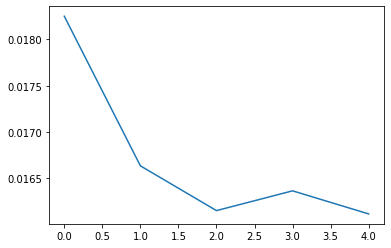

In [32]:
# plot the loss per epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [34]:
# Use the trained model to generate and store our test predictions
test_predictions = []

first_eval_batch = scaled_cpi_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
n=0

for i in range(len(scaled_cpi_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # remove the first value and update the batch with the next value from the test set
    current_batch = np.append(current_batch[:,1:,:],scaled_cpi_test[n:n+1].reshape((1, 1, n_features)),axis=1)
    n += 1



In [36]:
# Convert our predictions back to their pre scaled forms
true_predictions = scaler.inverse_transform(test_predictions)

# Apend the predictions back to the test data set
cpi_test['Predictions'] = true_predictions

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Test RMSE: 0.0030784026279769673


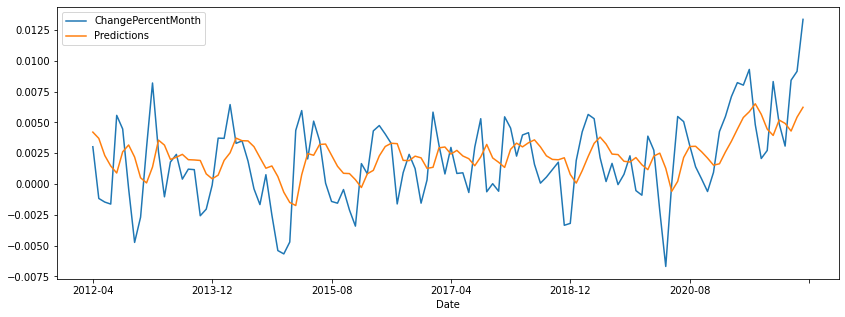

In [37]:
cpi_test.set_index('Date', inplace = True)
cpi_test.plot(figsize=(14,5))
uni_rmse=sqrt(mean_squared_error(cpi_test['ChangePercentMonth'],cpi_test['Predictions']))
print('Test RMSE:' , uni_rmse)

### Multivariate Forecasting of CPI with LTSMD

#### Data Preparation
For this section, we will aim to create a Long Short Term Memory model which accepts inputs from a variety of predictors to forecast CPI.

We will use the 4 highest correlated variables based on monthly percentage change that we found in the Data Visualisation part of this project: LaggedCPI, PPI, unemployment rates, and oil prices.


In [57]:
# Import all datasets
oil_data_clean = pd.read_csv('cleaned_oil.csv')
ppi_data_clean = pd.read_csv('cleaned_ppi.csv')
unemp_data_clean = pd.read_csv('cleaned_unemp.csv')
lcpi_data_clean = pd.read_csv('cleaned_lagged_cpi.csv')
cpi_data_clean = pd.read_csv('cleaned_cpi.csv')

For this model, we will be using the monthly change data as inputs. We will thus clean and compile the datasets as such.

In [58]:
oil_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
ppi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
unemp_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
lcpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
cpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)

In [59]:
oil_data_clean.columns = ['Date','Oil']
oil_data_clean.dropna(inplace = True)
ppi_data_clean.columns = ['Date','PPI']
ppi_data_clean.dropna(inplace = True)
unemp_data_clean.columns = ['Date','Unemployment']
unemp_data_clean.dropna(inplace = True)
lcpi_data_clean.columns = ['Date','LaggedCPI']
lcpi_data_clean.dropna(inplace = True)
cpi_data_clean.columns = ['Date','CPI']
cpi_data_clean.dropna(inplace = True)

dataframe_list = [cpi_data_clean, oil_data_clean, ppi_data_clean, unemp_data_clean, lcpi_data_clean]
# Join all datasets together
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), dataframe_list)
df_merged.set_index('Date', inplace = True)

With our data prepared and time period selected, lets do a quick plot of our datasets

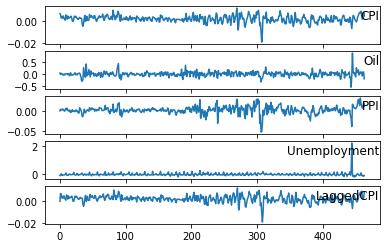

In [60]:
values = df_merged.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_merged.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### Data Preparation for LSTM Model

We will be using the last month of data to predict CPI

In [61]:
df_merged

,CPI,Oil,PPI,Unemployment,LaggedCPI
Date,,,,,
1983-04,0.007150,0.046464,0.000000,-0.074074,0.000000
1983-05,0.006085,-0.012406,0.003984,-0.020000,0.007150
1983-06,0.003024,0.037355,0.001984,0.040816,0.006085
1983-07,0.004020,0.019758,0.002970,-0.078431,0.003024
1983-08,0.003003,-0.012813,0.004936,-0.021277,0.004020
...,...,...,...,...,...
2021-07,0.004811,0.006533,0.012888,-0.065574,0.009291
2021-08,0.002066,-0.073698,0.006750,-0.070175,0.004811
2021-09,0.002716,0.095328,0.009695,-0.132075,0.002066


453 Total Rows. Split to allow last 8 years for testing

Train set = first 357 rows

Test set = last 96 rows

In [75]:
# Splitting the dataset into train and test sets
df_train = df_merged.iloc[:357]
df_test = df_merged.iloc[357:]

In [76]:
# Use MinMaxScaler to normalise are values by scaling down values between a range of -1 to 1
# Instantiate scaler objects
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

x_train = x_scaler.fit_transform(df_train[['Oil','PPI','Unemployment','LaggedCPI']])
y_train = y_scaler.fit_transform(df_train[['CPI']])

x_test = x_scaler.transform(df_test[['Oil','PPI','Unemployment','LaggedCPI']])
y_test = y_scaler.transform(df_test[['CPI']])

In [77]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(357, 1, 4) (357, 1) (107, 1, 4) (107, 1)


We will define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 4 features.

We will use the Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 30 training epochs.

Epoch 1/30
357/357 - 3s - loss: 0.0302 - val_loss: 0.0218 - 3s/epoch - 7ms/step
Epoch 2/30
357/357 - 1s - loss: 0.0168 - val_loss: 0.0272 - 755ms/epoch - 2ms/step
Epoch 3/30
357/357 - 1s - loss: 0.0165 - val_loss: 0.0324 - 745ms/epoch - 2ms/step
Epoch 4/30
357/357 - 1s - loss: 0.0163 - val_loss: 0.0391 - 751ms/epoch - 2ms/step
Epoch 5/30
357/357 - 1s - loss: 0.0162 - val_loss: 0.0466 - 782ms/epoch - 2ms/step
Epoch 6/30
357/357 - 1s - loss: 0.0161 - val_loss: 0.0548 - 770ms/epoch - 2ms/step
Epoch 7/30
357/357 - 1s - loss: 0.0160 - val_loss: 0.0634 - 746ms/epoch - 2ms/step
Epoch 8/30
357/357 - 1s - loss: 0.0159 - val_loss: 0.0723 - 775ms/epoch - 2ms/step
Epoch 9/30
357/357 - 1s - loss: 0.0159 - val_loss: 0.0814 - 755ms/epoch - 2ms/step
Epoch 10/30
357/357 - 1s - loss: 0.0158 - val_loss: 0.0907 - 712ms/epoch - 2ms/step
Epoch 11/30
357/357 - 1s - loss: 0.0157 - val_loss: 0.1000 - 782ms/epoch - 2ms/step
Epoch 12/30
357/357 - 1s - loss: 0.0156 - val_loss: 0.1093 - 868ms/epoch - 2ms/step
Epoc

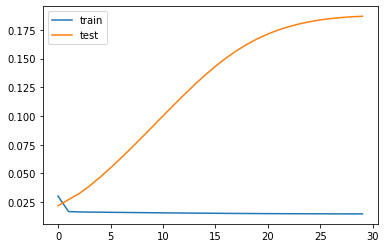

In [78]:
# design network with 100 neurons
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=1, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now that our model is trained, lets test it on our test set and evaluate the model

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Test RMSE: 0.006780220473818365


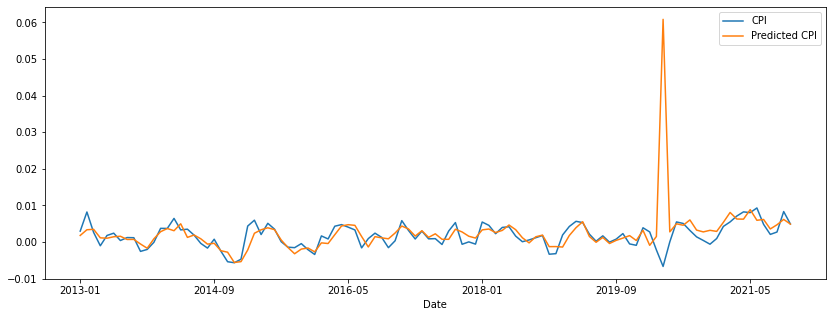

In [79]:
# make a prediction
yhat = model.predict(x_test)
# invert scaling for our forcast
inv_yhat = y_scaler.inverse_transform(yhat)
# Add our forecast to the test dataframe and plot the results
df_test['Predicted CPI'] = inv_yhat
df_test[['CPI','Predicted CPI']].plot(figsize=(14,5))
# Calculate RMSE
multi_rmse=sqrt(mean_squared_error(df_test['CPI'],df_test['Predicted CPI']))
print('Test RMSE:' , multi_rmse)

In [80]:
df_test

,CPI,Oil,PPI,Unemployment,LaggedCPI,Predicted CPI
Date,,,,,,
2013-01,0.002957,0.061751,0.004963,0.118421,-0.002693,0.001781
2013-02,0.008190,-0.055801,0.008889,-0.047059,0.002957,0.003340
2013-03,0.002615,0.056274,-0.001468,-0.061728,0.008190,0.003455
2013-04,-0.001040,-0.038774,-0.002451,-0.065789,0.002615,0.001127
2013-05,0.001780,-0.015943,0.002948,0.028169,-0.001040,0.001025
...,...,...,...,...,...,...
2021-07,0.004811,0.006533,0.012888,-0.065574,0.009291,0.006147
2021-08,0.002066,-0.073698,0.006750,-0.070175,0.004811,0.003553
2021-09,0.002716,0.095328,0.009695,-0.132075,0.002066,0.004700


### Discussion

#### Root Mean Squared Error Immediate Insights

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the actual CPI change data the forecasted values are and RMSE is a measure of how spread out these residuals are. RMSE is an easy general metric we can use to evaluate our LSTM models on the accuracy of their predictions. 

The resulting RMSEs are:

In [82]:
print('Univariate Long Short Memory Network RMSE:' , uni_rmse)
print('Multivariate Long Short Memory Network RMSE:' , multi_rmse)

Univariate Long Short Memory Network RMSE: 0.0030784026279769673
Multivariate Long Short Memory Network RMSE: 0.006780220473818365


Looking at RMSE scores, it appears that the Univariate LSTM model is more accurate than the Multivariate LSTM model at predicing monthly CPI change. 

However, taking a look at the graph for Predicted vs Actual values for the multivariate LSTM model shows a giant temporary divergence between predicted and actual values around the start of 2020. Without this anomaly, it appears that the multivariate model manages to predict CPI change pretty well and would probably have a much close RMSE score to the univariate model if we removed this anomalous period from the testing phase.

This anomaly could have been cause by the start of the Covid-19 pandemic which coincides with the time period that this anomaly happens. Since the multivariate LSTM model takes into account other independent predictors, namely oil prices, producer price index (PPI) and unemployment rates, it is possible that one or several of these variables was severely impacted by the onset of the pandemic, resulting in a corresponding huge spike in predicted CPI change by our model which did not materialise in the real world. 

Such an event captured in our out of sample data is hard to model as this pandemic is extremely out of the norm and would be hard to train for. Should such similar models be used in the future for prediction of CPI, it would be advisable for the user to keep in mind their current world order and to take note of any extremities that could cause erroneously large mispredictions like the one we have witnessed here.

#### Improvements and future developments using LSTM to predict CPI
While we managed to create two seemingly capable LSTM models here to predict CPI, there is still a lot that can be explored to optimise these models and create improved models. Some future developments that could be explored are:

##### Trying other variables
We only managed to train our LSTM models using predictors such as oil price and unemployment data. It would be interesting to see how LSTM models trained with the other factors such as s&p500 and bitcoin price could perform and if they might even have an outperformance as opposed to the comparative performance we have seen in our K-Nearest Neighbours, ARIMA, and Linear Regression models.

##### Training and testing on different time periods
The two models trained were only trained using sequentially older data and tested on the most recent years. Looking at how tumultous the past two years have been for inflation and CPI due to Covid-19, it would be beneficial to see how a model trained on the most recent years would perform. It would also be insightful to see how this subsequent model would perform on out of sample data from another period such as the 1990s.

##### Hyperparamter turning
Like any other maching learning mode, LSTMs and RNNs have a lot of hyperparameters that can be further tuned to optimise the models. Some examples of parameters that we can tune are number of epochs when traning, number of dense layers, if we want to include any additional layers, number of neurons in our model,and much more.

##### Modelling with limitations in mind
As this is time series data, it would be insightful to explore features of our dataset such as seasonality and staionarity. For example if our data was seasonal, the LSTM model could be modeled in a way that would try to predict the cyclic nature of CPI (if it exists).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=253c1e0f-50f6-4ff7-bced-2dba4c93b9cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>